В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

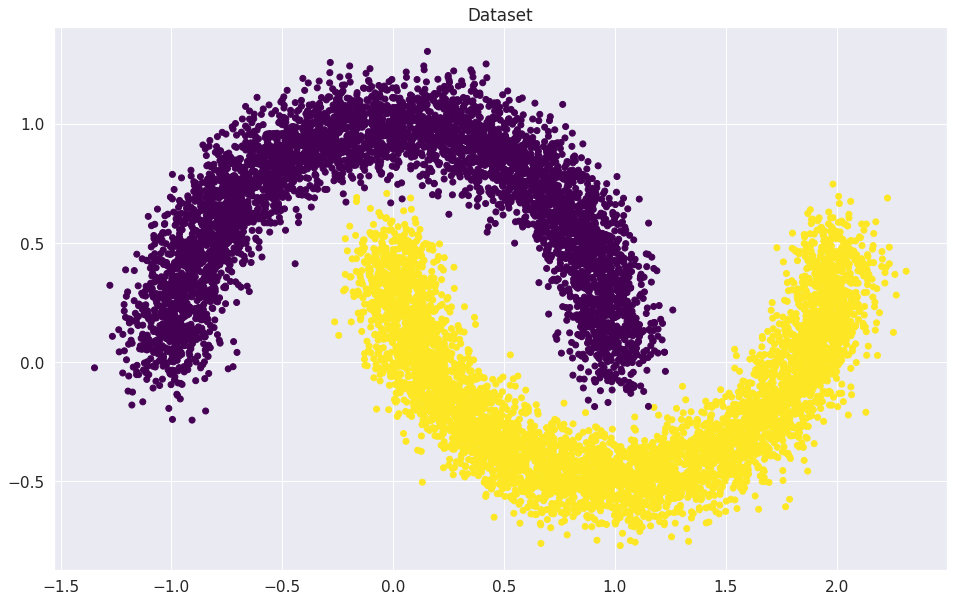

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.8)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
X_train_t =  torch.from_numpy(X_train)
y_train_t =  torch.from_numpy(y_train)
X_val_t =  torch.from_numpy(X_val)
y_val_t =  torch.from_numpy(y_val)

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    '''Это если что логистическая регрессия на 2 класса'''
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.rand(out_features, 1))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [20]:
linear_regression = LinearRegression(2, 1).double()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [18]:
list(linear_regression.named_parameters())

[('weights',
  Parameter containing:
  tensor([[-1.1126],
          [-0.1850]], dtype=torch.float64, requires_grad=True)),
 ('bias_term',
  Parameter containing:
  tensor([[0.0664]], dtype=torch.float64, requires_grad=True))]

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

У обучаемой модели 2 обучаемых параметра, если вектор весов мыслить как один параметр и 3 обучаемых параметра, если вектор весов мыслить как 2 параметра.

In [21]:
# Если вектор весов мыслить как 2 разных параметра:
param_number = 0
for p in linear_regression.parameters():
    param_number += p.shape[0]
param_number

7

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

Мы проходимся по всем батчам и для каждого объекта из батча делаем x @ w + b - получаем одиночный логит для каждого объекта батча

.detach() - возвращает тензор, для которого не нужно градиенты считать, то есть у него не просто не стоит флаг false, он даже не находится на графе вычислений. (it is detached from the computational graph), также он шейрит одну память с переменной.

In [129]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        X_batch = X_batch.to(torch.double)
        y_batch = y_batch.to(torch.double)

        optimizer.zero_grad()
        outp = linear_regression.forward(X_batch.type(torch.DoubleTensor))

        loss = loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.1484375
Iteration: 100
Batch accuracy: 0.640625
Iteration: 200
Batch accuracy: 0.765625
Iteration: 300
Batch accuracy: 0.796875
Iteration: 400
Batch accuracy: 0.8046875
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.8359375
Iteration: 700
Batch accuracy: 0.8359375

Iteration: 776.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся? (параметры парктически перестали изменяться)

**Ответ:** 776 итераций(примерно на середине 5 эпохи все сошлось)

### Визуализируем результаты

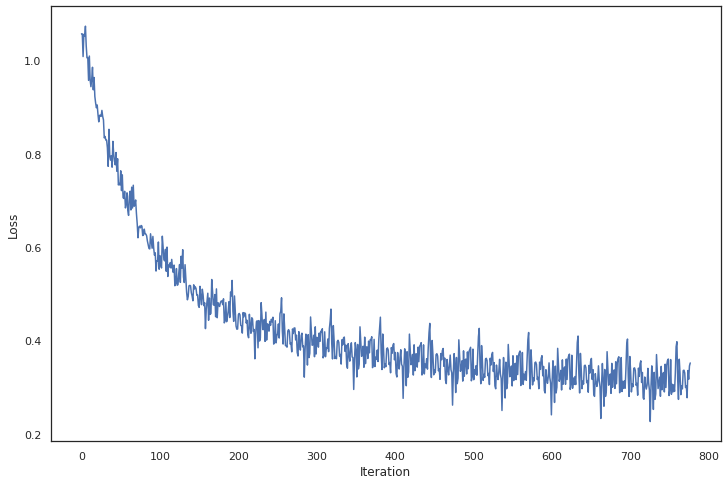

In [130]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

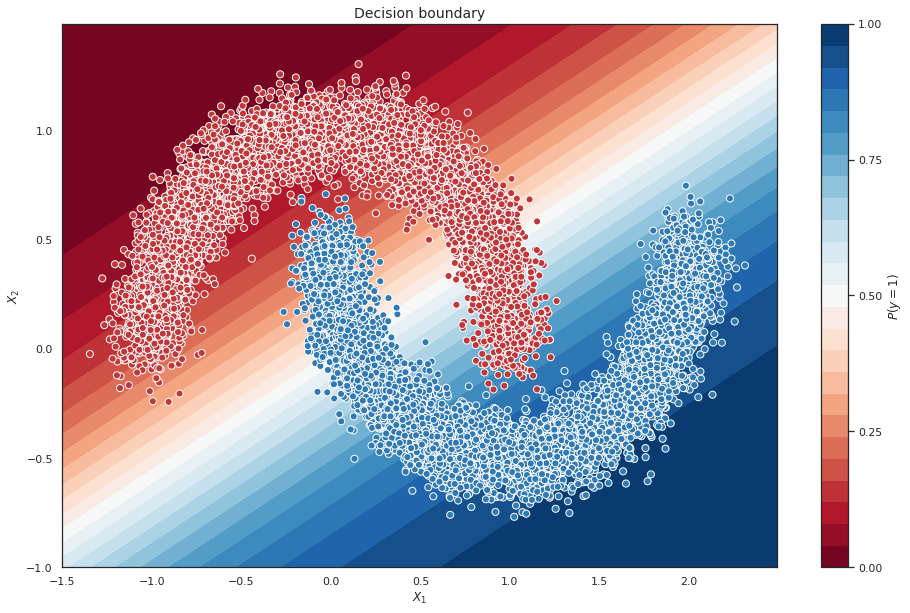

In [131]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.double)
with torch.no_grad():
    probs = torch.sigmoid(
        (linear_regression(batch).to(torch.double)).reshape(xx.shape)
        )
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

model.eval() переводит модель в стейт оценки качества, отключая некоторые функции модели, но потом надо не забыть обратно делать model.train()

In [152]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model.forward(x_batch)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return sigmoid(predictions.flatten()) > 0.5

y_preds = predict(val_dataloader, linear_regression).astype(int)

In [139]:
from sklearn.metrics import accuracy_score

In [153]:
accuracy_score(y_val, y_preds)

0.865

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.865